In [46]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from kitchenoptimiser import io
from kitchenoptimiser.utils import draw_process, draw_layout
from kitchenoptimiser.volumeoperators import VolumeOperator
from kitchenoptimiser.scorers import DistanceScorer, VisibilityScorer

In [48]:
ALL_THINGS = io.read_things(r'things.json')
ALL_PLACES = io.read_locations(r'locations.json')
LAYOUT = io.read_layout(r'layout.json')
PROCESS_DETAILS = io.read_process_details(r'process_details2.json')

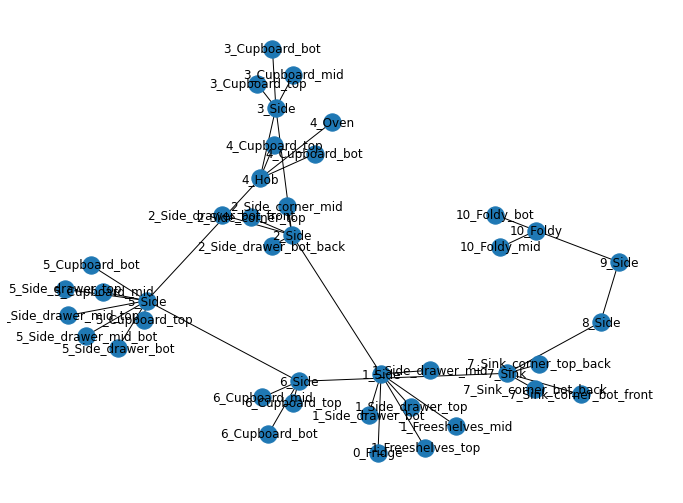

In [49]:
draw_layout(LAYOUT)

[('kettle', 'mugs', {'weight': 0.5}), ('kettle', 'fancy_mugs', {'weight': 0.5}), ('kettle', 'tea_stuff', {'weight': 1}), ('kettle', '0_Fridge', {'weight': 1})]


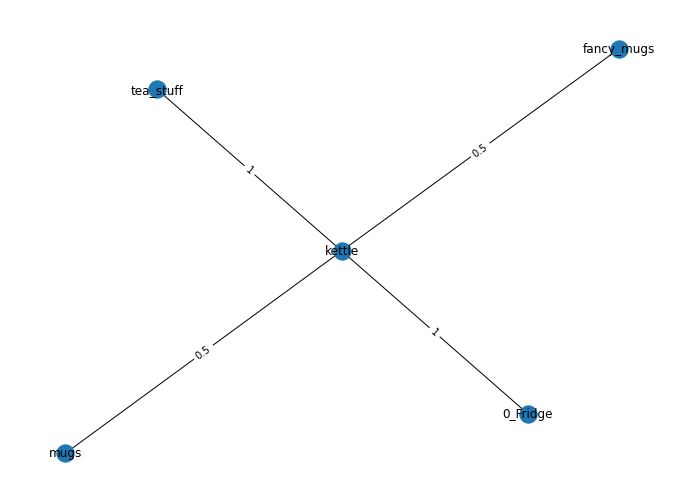

In [50]:
print(PROCESS_DETAILS['cup_of_tea']['process'].edges(data=True))
draw_process(PROCESS_DETAILS['cup_of_tea']['process'])

Set up fixed positions and define the operators I'll use.

In [51]:
FIXED_POSITIONS = {
    '0_Fridge': '0_Fridge',
    '4_Hob': '4_Hob',
    '4_Oven': '4_Oven',
    '7_Sink': '7_Sink',
}

operators = VolumeOperator(all_things=ALL_THINGS,
                           all_places=ALL_PLACES,
                           fixed_assignments=FIXED_POSITIONS,
                           swap_chance=.1)

distance_scorer = DistanceScorer(LAYOUT, PROCESS_DETAILS)
visibility_scorer = VisibilityScorer(ALL_PLACES, ALL_THINGS)

## Set up DEAP
In many cases this means wrapping the pre-defined functions to return the correct classes.

In [52]:
from deap import creator, base, tools
from deap.algorithms import eaSimple

In [53]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def deap_create_gene(icls):
  return icls(operators.create_gene())

def deap_mate(icls, individual1, individual2):
    child1, child2 = operators.mate(individual1, individual2)
    return icls(child1), icls(child2)

def deap_evaluate_minus(individual):
  "Need to return a tuple"
  thing_place_dict_all = operators.get_thing_place_dict(individual, include_fixed=True)
  thing_place_dict_nonfixed = operators.get_thing_place_dict(individual, include_fixed=False)

  distance_score = distance_scorer.get_score(thing_place_dict_all)
  visibility_score = visibility_scorer.get_score(thing_place_dict_nonfixed)

  return -distance_score + 100*visibility_score,

toolbox = base.Toolbox()
toolbox.register("individual", deap_create_gene, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mutate", operators.mutate)
toolbox.register("mate", deap_mate, creator.Individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", deap_evaluate_minus)

## Set up some things we wish to log

In [54]:
def get_max_fitness(individuals):
    max_fitness = max(individuals, key=lambda x: x.fitness.wvalues[0]).fitness.wvalues[0]
    return f"{max_fitness:.2f}"  # Print nicely

s = tools.Statistics()
s.register("max_fitness", get_max_fitness)

In [55]:
final_population = eaSimple(population=toolbox.population(n=100),
                            toolbox=toolbox,
                            cxpb=.1,
                            mutpb=.3,
                            ngen=100,
                            stats=s)

gen	nevals	max_fitness
0  	100   	-21446.60  


TypeError: unhashable type: 'Thing'